# Plot flow cytometry of direct transfection of Cre mRNA

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/flow_Cre_mRNA_transfection"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

In [4]:
from scipy.optimize import curve_fit

In [5]:
# Define Hill function

def hill(x, k_max, k_half, n):
    return k_max * np.power(x, n) / (np.power(k_half, n) + np.power(x, n))

# Load data

In [6]:
infile = "../preprocessed_data/flow_data/flow_Cre_mRNA_transfection_summary.csv"

df_raw = pd.read_csv(infile, index_col=0)

print(df_raw.shape)
df_raw

(36, 17)


,Well Number,Condition Number,Condition Name,Dosage,Exporter?,Cargo?,Export Tag?,Fusogen?,Total Ungated Events (Depth: 0),Putative Acacia reporter Events (Depth: 1),% of Putative Acacia reporter Events in Total Events,Singlet Gated Acacia reporter Events (Depth: 2),% of Singlet Gated Events in Putative Acacia reporter Events,GFP-A Events in Acacia reporter Singlet (Depth: 3),% of GFP-A Events in Acacia reporter Singlet,mCherry-A Events in GFP-A POI (Depth: 4),% of mCherry-A Events in GFP-A POI
Plate Number,,,,,,,,,,,,,,,,,
1,A1,1,allRNA_Transfection_Reagents_Alone,0.0,-,-,-,-,40000,25163,62.9075,23967,95.246990,22876,95.447908,27,0.118028
1,A2,2,allRNA_Transfection_Reagents_Alone,0.0,-,-,-,-,40000,26144,65.3600,24850,95.050490,23780,95.694165,28,0.117746
1,A3,3,allRNA_Transfection_Reagents_Alone,0.0,-,-,-,-,40000,25139,62.8475,24008,95.501014,23048,96.001333,28,0.121486
1,A4,4,allRNA_CreMS2_1500ng,1500.0,-,+,+,-,40000,24043,60.1075,23044,95.844944,19018,82.529075,16818,88.432012
1,A5,5,allRNA_CreMS2_1500ng,1500.0,-,+,+,-,40000,24640,61.6000,23754,96.404221,19621,82.600825,17305,88.196320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,C8,32,allRNA_CreMS2_1ng,1.0,-,+,+,-,40000,23682,59.2050,22422,94.679503,21438,95.611453,77,0.359175
1,C9,33,allRNA_CreMS2_1ng,1.0,-,+,+,-,40000,25277,63.1925,24104,95.359418,23011,95.465483,83,0.360697
1,C10,34,allRNA_Acacia_WT,NaN,-,-,-,-,40000,24810,62.0250,23528,94.832729,22512,95.681741,24,0.106610


# Preprocess data

In [7]:
# Create a dosage variable that has a pseudocount (for plotting on a log scale)
df_raw["Dosage_pseudocount"] = df_raw["Dosage"]
df_raw.loc[df_raw["Dosage_pseudocount"] == 0, "Dosage_pseudocount"] = 0.1  # set pseudocount

In [8]:
# Summarize replicates
summary = df_raw.groupby("Dosage_pseudocount").describe()["% of mCherry-A Events in GFP-A POI"][["mean", "std"]]
summary = summary.reset_index()

summary

,Dosage_pseudocount,mean,std
0,0.1,0.119086,0.002083
1,1.0,0.334248,0.044499
2,10.0,12.580116,0.838854
3,100.0,52.465174,4.431057
4,250.0,73.374425,1.900369
5,300.0,75.229412,2.252171
6,500.0,79.522215,1.089705
7,750.0,83.945495,1.461440
8,900.0,85.447148,0.942209
9,1000.0,85.729400,1.283639


# Fit model

In [9]:
# Select data

selector = ~df_raw["Dosage_pseudocount"].isna()
data = df_raw.loc[selector]

print(data.shape)
data.head()

(33, 18)


,Well Number,Condition Number,Condition Name,Dosage,Exporter?,Cargo?,Export Tag?,Fusogen?,Total Ungated Events (Depth: 0),Putative Acacia reporter Events (Depth: 1),% of Putative Acacia reporter Events in Total Events,Singlet Gated Acacia reporter Events (Depth: 2),% of Singlet Gated Events in Putative Acacia reporter Events,GFP-A Events in Acacia reporter Singlet (Depth: 3),% of GFP-A Events in Acacia reporter Singlet,mCherry-A Events in GFP-A POI (Depth: 4),% of mCherry-A Events in GFP-A POI,Dosage_pseudocount
Plate Number,,,,,,,,,,,,,,,,,,
1,A1,1,allRNA_Transfection_Reagents_Alone,0.0,-,-,-,-,40000,25163,62.9075,23967,95.246990,22876,95.447908,27,0.118028,0.1
1,A2,2,allRNA_Transfection_Reagents_Alone,0.0,-,-,-,-,40000,26144,65.3600,24850,95.050490,23780,95.694165,28,0.117746,0.1
1,A3,3,allRNA_Transfection_Reagents_Alone,0.0,-,-,-,-,40000,25139,62.8475,24008,95.501014,23048,96.001333,28,0.121486,0.1
1,A4,4,allRNA_CreMS2_1500ng,1500.0,-,+,+,-,40000,24043,60.1075,23044,95.844944,19018,82.529075,16818,88.432012,1500.0
1,A5,5,allRNA_CreMS2_1500ng,1500.0,-,+,+,-,40000,24640,61.6000,23754,96.404221,19621,82.600825,17305,88.196320,1500.0


In [10]:
# Fit model
x = data["Dosage"]
y = data["% of mCherry-A Events in GFP-A POI"]

initial_params = (90, 100, 1)

popt, pcov = curve_fit(hill, x, y, initial_params)

print("Fitted parameters:", popt)
print("Covariance matrix:", pcov)

Fitted parameters: [92.15352386 70.48122712  0.9909529 ]
Covariance matrix: [[ 1.31719229e+00  2.54598303e+00 -3.82111029e-02]
 [ 2.54598303e+00  1.16773244e+01 -3.27975150e-02]
 [-3.82111029e-02 -3.27975150e-02  1.76423309e-03]]


In [11]:
# Calculate fitted curve
x_fitted = np.linspace(np.min(x), np.max(x), 100)
y_fitted = hill(x_fitted, popt[0], popt[1], popt[2])

# Plot reporter activation (% RFP+ cells)

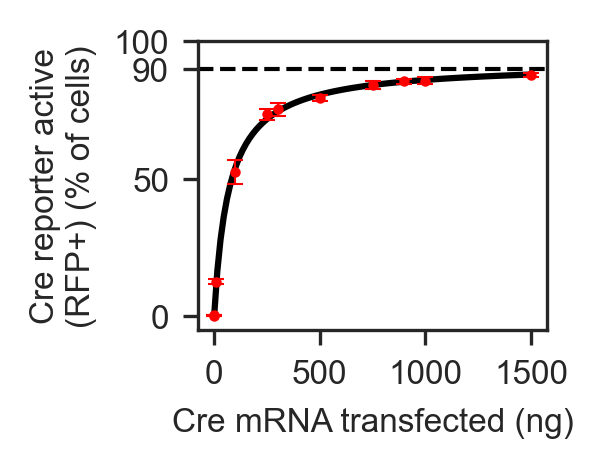

In [12]:
# Plot with model fit

x_fitted = np.linspace(np.min(x), np.max(x), 100)

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.25))

# sns.scatterplot(ax=ax, data=summary, x="Dosage_pseudocount", y="mean", s=20, zorder=10, legend=False)

ax.errorbar(x=summary["Dosage_pseudocount"],
            y=summary["mean"],
            yerr=summary["std"],
            marker=".",
            markersize=3,
            color="r",
            capsize=2,
            capthick=0.5,
            elinewidth=0.5,
            ls="none")

sns.lineplot(ax=ax, x=x_fitted, y=y_fitted, color="k", zorder=1, label="fit", legend=False)

ax.set_ylim(-5, 100)

ax.set_xticks([0, 500, 1000, 1500])
ax.set_yticks([0, 50, 90, 100])

ax.set_xlabel("Cre mRNA transfected (ng)")
ax.set_ylabel("Cre reporter active\n(RFP+) (% of cells)")

ax.axhline(y=90, ls="--", c="k", lw=1)

save_figure(fig, "scatter_RNA_transfected_vs_reporter_active_fit")